In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import os
import pickle
from dateutil.parser import parse
import datetime
from dateutil.parser import parse
import math
from numpy import mean

from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline as SKLpipeline
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
from sklearn.tree import export_text
import dtreeviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
import umap

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as IMBLpipeline

from sklearn.inspection import permutation_importance
import shap
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import warnings

from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

import ipynbname
notebook_name = ipynbname.name()

import seaborn as sns

pd.set_option("display.max_rows", 30)
pd.set_option("display.max_columns", 35)

2024-08-07 17:05:23.790319: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define directory path name and timestamp

# Get the current date and time as a string
timestamp = datetime.datetime.now().strftime('%d%m%Y_%H%M')

# Construct the directory path with the models folder and timestamp
dir_path = f"models/{timestamp}"
    
# Create the directory if it doesn't exist
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

In [3]:
import random
# Generate a random number between 0 and 100
# rand_num = random.randint(0, 10000)
rand_num = 9880

#save random state number
with open(f"{dir_path}/random_state_number-{notebook_name}-{timestamp}.txt", 'w') as f:
    f.write(str(rand_num))
print(rand_num)

9880


In [4]:
# read df pickle
# df_alg = pd.read_pickle("objects/df_alg-HAB_preprocessing_5_1")
df_alg = pd.read_pickle("ARCHIVE/objects_arch/df_alg-HAB_preprocessing_5_1")
# data = pd.read_pickle("data/preprocessed/hab_org-data-HAB_part2-preprocessing-5_2")
data = pd.read_pickle("data/preprocessed/hab_interp_data-HAB_part2-preprocessing-5_2")

data.drop(columns=["sampling station", "date"], inplace=True)
# data.set_index('date', inplace=True)


# slice by station and time
# data = data[data["sampling station"] == "Debeli_rtic"].loc["2008-01-01" : "2021-12-31"]

data.isnull().sum()

DSP                        1
Dinophysis caudata         1
Dinophysis fortii          1
Phalacroma rotundatum      1
Dinophysis sacculus        1
Dinophysis tripos          1
sun [h]                    0
air temp                   0
wind strength              0
precipitation              0
Chl-a                    422
salinity                  21
T                         59
SECCHI                   450
DIN                      352
PO4-P                    349
Soca                       0
month                      0
lipophylic_toxins        320
dtype: int64

In [5]:
# Class distribution
data["lipophylic_toxins"].value_counts(dropna=False)

neg    996
NaN    320
poz    136
Name: lipophylic_toxins, dtype: int64

In [6]:
# move month to first place
cols = data.columns.tolist()  # Get a list of column names
cols = [cols[-2]] + cols[:-2] + [cols[-1]]  # Move the one before the last column to the first position
data = data[cols]

In [7]:
data.drop(columns=["Chl-a","PO4-P","DIN","SECCHI"], inplace=True)
# data.drop(columns=["SECCHI"], inplace=True)
data.isnull().sum()

month                      0
DSP                        1
Dinophysis caudata         1
Dinophysis fortii          1
Phalacroma rotundatum      1
Dinophysis sacculus        1
Dinophysis tripos          1
sun [h]                    0
air temp                   0
wind strength              0
precipitation              0
salinity                  21
T                         59
Soca                       0
lipophylic_toxins        320
dtype: int64

In [8]:
data

,month,DSP,Dinophysis caudata,Dinophysis fortii,Phalacroma rotundatum,Dinophysis sacculus,Dinophysis tripos,sun [h],air temp,wind strength,precipitation,salinity,T,Soca,lipophylic_toxins
0,5,68.0,27.0,0.0,21.0,0.0,0.0,197.1,15.114286,2.933333,26.2,33.780000,13.580000,3030.486,NaN
3,5,17.0,8.0,0.0,0.0,0.0,0.0,197.1,15.114286,2.933333,26.2,36.180000,12.620000,3030.486,NaN
6,6,27.0,16.0,3.0,5.0,0.0,0.0,166.3,18.790476,3.157143,18.8,35.530000,17.030000,3931.331,NaN
7,6,23.0,3.0,0.0,0.0,0.0,0.0,179.1,18.533333,3.052381,23.9,35.010000,19.890000,4090.322,NaN
8,6,20.0,8.0,0.0,0.0,0.0,0.0,157.5,19.095238,3.066667,29.8,36.170000,26.880000,3221.804,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,11,140.0,10.0,60.0,40.0,0.0,0.0,66.8,9.823810,2.738095,49.4,37.880001,15.500000,3392.723,poz
1648,11,50.0,0.0,30.0,20.0,0.0,0.0,66.8,9.823810,2.738095,49.4,37.860001,15.150000,3392.723,poz
1650,12,10.0,0.0,0.0,10.0,0.0,0.0,64.4,6.371429,2.980952,114.4,37.880001,15.500000,3357.036,neg
1649,12,60.0,0.0,20.0,30.0,0.0,0.0,64.4,6.371429,2.980952,114.4,37.930000,16.030001,3357.036,neg


# Descriptive analysis

In [9]:
# describe
description = data.describe(include='all').round(0)
description = description.drop(['unique', 'top', 'freq'])

# Replace NaN values with "-" in the description
description = description.fillna("-")

# Convert numeric columns to integers
for col in description.select_dtypes(include=['float64']).columns:
    description[col] = description[col].astype(int)


# Calculate the number of missing values for each column
missing_values = data.isna().sum()
missing_values.name = 'missing_values'

# Append the missing_values row to the description DataFrame
description_with_missing = description.append(missing_values)
# description_with_missing = description_with_missing.drop(['unique', 'top', 'freq'])

# Transpose the DataFrame
transposed_description = description_with_missing.T
transposed_description


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,count,mean,std,min,25%,50%,75%,max,missing_values
month,1452,7,3,1,5,8,10,12,0
DSP,1451,106,340,0,10,37,90,7630,1
Dinophysis caudata,1451,25,88,0,0,0,13,1309,1
Dinophysis fortii,1451,26,160,0,0,0,10,4624,1
Phalacroma rotundatum,1451,14,30,0,0,10,20,393,1
Dinophysis sacculus,1451,29,178,0,0,0,10,4639,1
Dinophysis tripos,1451,5,41,0,0,0,0,1139,1
sun [h],1452,159,61,23,113,161,207,278,0
air temp,1452,17,6,-1,12,17,22,27,0
wind strength,1452,3,0,1,3,3,3,5,0


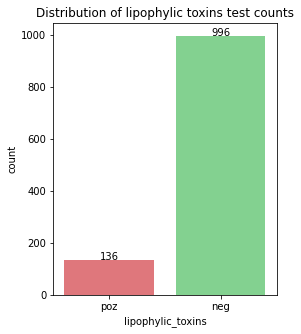

In [10]:
# Create a figure with a more narrow width
fig, ax = plt.subplots(figsize=(4, 5))

# Create a custom  pastel color palette
custom_pastel = sns.color_palette("bright")

# Set the color for class 1 to orange
custom_pastel[1] = sns.color_palette("bright")[2]
custom_pastel[0] = sns.color_palette("bright")[3]


# Create a count plot
sns.countplot(data=data, x="lipophylic_toxins", ax=ax, palette=custom_pastel, alpha=0.6)
ax.set_title('Distribution of lipophylic toxins test counts')

# Add numbers on top of the bars
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height() + 0.5,
            p.get_height(), ha='center', fontsize=10)

# Show the plot
plt.savefig(f"{dir_path}/lipophylic_toxins_test_counts-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300)
plt.show()

## Descriptive analysis by month

In [11]:
# table of mean values for each feature by month 
import calendar

grouped_means = data.groupby('month').mean()

# Count binary values for the categorical feature grouped by month
binary_counts = data.groupby('month')['lipophylic_toxins'].value_counts().unstack()

# Calculate the ratio of positive values for each month
sum_positive = binary_counts["poz"].sum()
positive_ratios = [i for i in (binary_counts["poz"] / sum_positive)] 
positive_ratios = [round(v * 100, 1) for v in positive_ratios]

# Change month names
month_names = {i: calendar.month_name[i] for i in range(1, 13)}

# Update the index using the month_names dictionary
grouped_means.index = grouped_means.index.map(month_names)
binary_counts.index = binary_counts.index.map(month_names)

# Concatenate the grouped_means and binary_counts DataFrames
result = pd.concat([grouped_means, binary_counts], axis=1).round(2)

# Add the positive_ratios Series as a new column to the result DataFrame
result["poz %"] = positive_ratios
result.to_csv(f"{dir_path}/features_by_month_A-{notebook_name}-{timestamp}.csv", index=True)

result

,DSP,Dinophysis caudata,Dinophysis fortii,Phalacroma rotundatum,Dinophysis sacculus,Dinophysis tripos,sun [h],air temp,wind strength,precipitation,salinity,T,Soca,neg,poz,poz %
month,,,,,,,,,,,,,,,,
January,9.00,1.16,2.96,3.66,0.09,0.20,72.62,4.95,2.71,46.53,36.95,11.07,4652.16,15,3,2.2
February,12.86,1.02,4.08,3.38,0.20,0.69,80.19,5.52,3.06,60.66,37.02,10.22,4378.79,21,3,2.2
March,12.38,0.21,0.68,3.79,0.43,0.64,118.56,7.55,3.30,30.01,37.17,9.49,3257.07,28,2,1.5
April,15.49,0.97,0.48,5.24,4.51,0.00,144.63,11.69,3.17,54.90,36.93,11.68,3826.10,66,2,1.5
May,59.00,6.00,0.97,9.67,34.25,0.15,171.96,16.22,2.89,48.55,36.57,14.87,3864.97,89,14,10.3
June,146.89,29.23,1.49,12.87,93.28,0.09,202.85,20.51,2.83,45.16,35.60,20.28,3436.93,115,12,8.8
July,237.04,67.07,44.50,19.57,97.25,0.04,227.47,23.31,2.88,38.27,35.40,23.48,2473.18,125,18,13.2
August,129.67,55.46,24.23,19.01,22.96,0.08,220.46,23.46,3.03,54.38,41.92,24.93,1637.28,126,11,8.1
September,116.79,28.04,58.58,12.81,3.57,6.04,174.65,20.06,3.11,69.73,36.59,24.38,2102.01,143,31,22.8


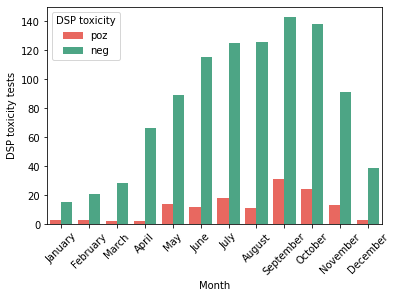

In [12]:
# Plot toxins distribution by month

# Load the dataset (replace 'file_path' with the actual path to your CSV file)
data_org = pd.read_pickle("data/preprocessed/hab_interp_data-HAB_part2-preprocessing-5_2")

# Replace '?' with NaN to properly handle missing values
data_org['lipophylic_toxins'] = data_org['lipophylic_toxins'].replace('?', pd.NA)

# Count 'poz' and 'neg' occurrences for each month, handling NaN values by setting them to False
poz_counts = data_org[data_org['lipophylic_toxins'].str.contains('poz', na=False)].groupby('month').size().reset_index(name='Count')
poz_counts['Toxin Type'] = 'poz'
neg_counts = data_org[data_org['lipophylic_toxins'].str.contains('neg', na=False)].groupby('month').size().reset_index(name='Count')
neg_counts['Toxin Type'] = 'neg'

# Combine the counts into a single DataFrame
all_counts = pd.concat([poz_counts, neg_counts])

# Assuming the 'month' column in 'all_counts' is numeric, convert it to month names
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
all_counts['month'] = all_counts['month'].apply(lambda x: month_names[int(x)-1])

# Define custom colors with transparency using RGBA format
# custom_palette = {'neg': '#3eb489', 'poz': '#ff5349'}
custom_palette = {'poz': (1, 0.328, 0.286, 0.5),  # Red with 70% opacity
                  'neg': (0.243, 0.706, 0.537, 0.5)}  # Green with 70% opacity

# Plot with Seaborn
sns.barplot(x='month', y='Count', hue='Toxin Type', data=all_counts, palette=custom_palette)

# Add labels and title
plt.xlabel('Month')
plt.ylabel('DSP toxicity tests')
# plt.title('Count of Positive and Negative Lipophylic Toxins by Month')

plt.legend(title="DSP toxicity")

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.savefig(f"{dir_path}/target_distribution_month-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()

# Data preprocessing for modelling

## Removing instances with unlabeled target, label encoding

In [13]:
# Prepare for ML in scikit-learn
# labeled and unlabeled part
data_l = data[data['lipophylic_toxins'].notnull()]
data_ul = data[data['lipophylic_toxins'].isnull()]

# Remove missing values
data_l = data_l.dropna(how="any")
print(f"class distribution:")
print(data_l["lipophylic_toxins"].value_counts(dropna=False))

X = data_l.drop("lipophylic_toxins", axis=1)
y = data_l["lipophylic_toxins"]

# sklearn lable encoding
le = LabelEncoder()
le.fit(y)
y = le.transform(y)
print(f"class encoding: ['neg','poz'] -> {le.transform(['neg','poz'])}")

class distribution:
neg    956
poz    132
Name: lipophylic_toxins, dtype: int64
class encoding: ['neg','poz'] -> [0 1]


## Dimensionality reduction

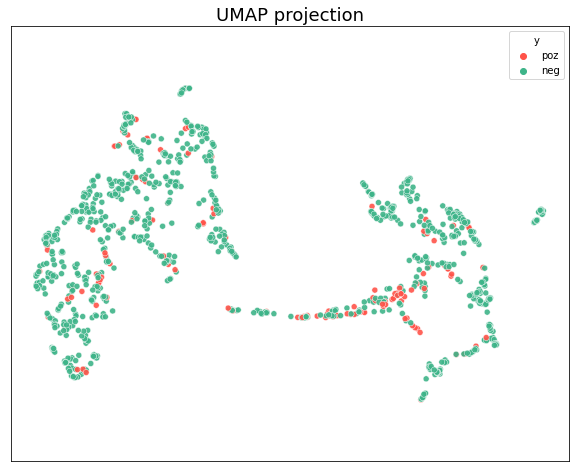

In [14]:
# Using UMAP for dimensionality reduction and visualisation before removing similar instances 
# Initialize UMAP

reducer = umap.UMAP(n_components=2, metric="correlation", random_state=rand_num)

# Fit and transform the data
embedding = reducer.fit_transform(X)

# Create a DataFrame for seaborn
df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
df['y'] = pd.Series(y).map({0: 'neg', 1: 'poz'})

# Create a color palette dictionary with pastel colors
color_mapping = {'neg': '#3eb489', 'poz': '#ff5349'}

# Plot using seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='y', data=df, palette=color_mapping, alpha=0.9)

# Remove x and y axis names
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=18)
plt.savefig(f"{dir_path}/umap_before_removal-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()

## Clean instances close to the decision boundary

Clean the dataset by removing samples close to the decision boundary. Because the dataset is heavily imbalanced in favor of clas 0 (neg) we will remove instances from this class whenever finding samples which do not agree “enough” with their neighboorhood. The EditedNearestNeighbours will be used. One other option is to use Tomek links but it is more conservative and was found to perform slightly worse.

In [15]:
from collections import Counter
from imblearn.under_sampling import TomekLinks, RepeatedEditedNearestNeighbours

print(f'Original dataset shape: {Counter(y)}')
usmp = RepeatedEditedNearestNeighbours()
lastMajorityCount = Counter(y)[0]
X_res, y_res = usmp.fit_resample(X, y)
print(f'Resampled dataset shape {Counter(y_res)}')
X = X_res
y = y_res    

Original dataset shape: Counter({0: 956, 1: 132})
Resampled dataset shape Counter({0: 745, 1: 132})


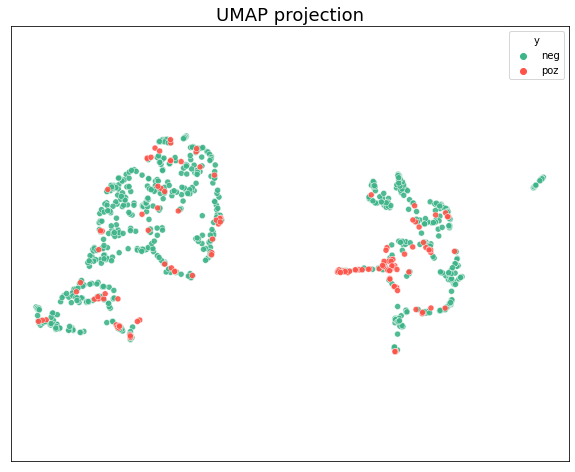

In [16]:
# Using UMAP for dimensionality reduction and visualisation after removing similar instances 
# Initialize UMAP

reducer = umap.UMAP(n_components=2, metric="correlation", random_state=rand_num)

# Fit and transform the data
embedding = reducer.fit_transform(X)

# Create a DataFrame for seaborn
df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
df['y'] = pd.Series(y).map({0: 'neg', 1: 'poz'})

# Create a color palette dictionary with pastel colors
color_mapping = {'neg': '#3eb489', 'poz': '#ff5349'}

# Plot using seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='y', data=df, palette=color_mapping, alpha=0.9)

# Remove x and y axis names
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=18)
plt.savefig(f"{dir_path}/umap_after_removal-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()


# Descriptive statistics before split

In [17]:
X_stat = X.copy()
y_stat = y.copy()
y_stat = np.where(y == 0, 'neg', np.where(y == 1, 'poz', y))
X_stat["lipophylic_toxins"] = y_stat

# describe
description = X_stat.describe(include='all').round(0)
description = description.drop(['unique', 'top', 'freq'])

# Replace NaN values with "-" in the description
description = description.fillna("-")

# Convert numeric columns to integers
for col in description.select_dtypes(include=['float64']).columns:
    description[col] = description[col].astype(int)


# Calculate the number of missing values for each column
missing_values = data_l.isna().sum()
missing_values.name = 'missing_values'

# Append the missing_values row to the description DataFrame
description_with_missing = description.append(missing_values)
# description_with_missing = description_with_missing.drop(['unique', 'top', 'freq'])

# Transpose the DataFrame
transposed_description = description_with_missing.T
transposed_description

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,count,mean,std,min,25%,50%,75%,max,missing_values
month,877,8,3,1,6,8,10,12,0
DSP,877,93,285,0,10,40,80,5760,0
Dinophysis caudata,877,21,87,0,0,0,10,1309,0
Dinophysis fortii,877,23,119,0,0,0,10,2341,0
Phalacroma rotundatum,877,15,31,0,0,10,20,393,0
Dinophysis sacculus,877,26,174,0,0,0,10,4639,0
Dinophysis tripos,877,2,11,0,0,0,0,110,0
sun [h],877,162,60,30,116,165,212,278,0
air temp,877,17,6,-1,13,18,22,27,0
wind strength,877,3,0,1,3,3,3,5,0


In [18]:
X_stat["lipophylic_toxins"].value_counts()

neg    745
poz    132
Name: lipophylic_toxins, dtype: int64

## Train-test split

In [19]:
# All data
import copy

X_all = copy.copy(X)
y_all = copy.copy(y)

# train test split
X, X_eval, y, y_eval = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.30, random_state=rand_num) 

# Save X, X_eval, y, y_eval 
X.to_csv(f"{dir_path}/X_train.csv", index=False)
X_eval.to_csv(f"{dir_path}/X_test.csv", index=False)
pd.Series(y).to_csv(f"{dir_path}/y_train.csv", index=False)
pd.Series(y_eval).to_csv(f"{dir_path}/y_test.csv", index=False)

# # # Load 
# # X = pd.read_csv('X_train.csv')
# # X_eval = pd.read_csv('X_test.csv')
# y = pd.read_csv(f"{dir_path}/y_train.csv", squeeze=True).values
# y_eval = pd.read_csv(f"{dir_path}/y_test.csv", squeeze=True).values

# Model Training and Evaluation

In [20]:
# Saving models

# Function to save best estimator
def save_best_estimator(grid_search_cv, classifier_name, notebook_name):
    # Get the best estimator from the GridSearchCV object
    best_estimator = grid_search_cv.best_estimator_

    # Construct the file name with the classifier name and notebook name
    pickle_file_name = f"{dir_path}/{classifier_name}-{notebook_name}-{timestamp}.pkl"
    
    # Save the best estimator to the file
    with open(pickle_file_name, 'wb') as f:
        pickle.dump(best_estimator, f)

    print(f"Best estimator saved as: {pickle_file_name}")

In [21]:
# Function for loading saved models

def load_best_estimator(pickle_file_name):
    with open(pickle_file_name, 'rb') as f:
        best_estimator = pickle.load(f)
    return best_estimator

## SVM

In [22]:
pd.set_option("display.max_rows", None)

pipeline = IMBLpipeline([
    ('smt', SMOTE(random_state=rand_num)), 
    ('under', RandomUnderSampler(random_state=rand_num)), 
    ('clf', SVC(random_state=rand_num))
])

parameters = {
            'clf__C': [0.1, 0.5, 1, 3, 10, 100],
            # 'clf__gamma': ['scale', 'auto'],
            # 'clf__kernel': ['linear', 'rbf', 'poly'],
            'clf__class_weight': ['balanced', None],
            'smt__sampling_strategy': [ 0.2, 0.3, 0.4],
            'under__sampling_strategy': [0.5, 0.6, 0.7],
            'smt__k_neighbors': [1, 3, 5]
             }
nfolds = 5
scores = ['recall', 'precision', 'f1', 'roc_auc', 'recall_weighted']
gscv_svm = GridSearchCV(pipeline, 
                    parameters, 
                    scoring=scores,
                    cv=StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=rand_num),
                    return_train_score=False, 
                    verbose=1, 
                    refit="f1",
                    n_jobs=-1)
resultsGSCV = gscv_svm.fit(X, y)

# Get the classifier name from the pipeline
classifier_name = resultsGSCV.best_estimator_.named_steps['clf'].__class__.__name__
    
# save the best estimator
save_best_estimator(gscv_svm, classifier_name, notebook_name)

# Save best parameters 
SVM_best_params = gscv_svm.best_params_
df = pd.DataFrame([SVM_best_params])
df.to_csv(f"{dir_path}/SVM_best_params-{notebook_name}-{timestamp}.csv", index=False)

results = pd.DataFrame(resultsGSCV.cv_results_)
display(results.sort_values(by=[f'rank_test_f1']).transpose())

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best estimator saved as: models/07082024_1705/SVC-HAB_modelling_6_8-Review-Check-07082024_1705.pkl


,313,322,305,323,314,312,310,276,319,304,321,311,277,294,301,285,286,...,39,38,37,36,81,34,33,31,30,29,28,27,46,47,48,49,85
mean_fit_time,0.046194,0.044901,0.042756,0.035368,0.044496,0.04996,0.038729,0.053087,0.039898,0.04689,0.051727,0.039652,0.049708,0.060263,0.037279,0.060454,0.057608,...,0.034703,0.02915,0.031075,0.030353,0.03215,0.040994,0.050214,0.037156,0.039598,0.07353,0.050183,0.051967,0.038308,0.038214,0.047363,0.04195,0.036977
std_fit_time,0.003902,0.002724,0.004888,0.00595,0.003344,0.002615,0.005238,0.003577,0.005616,0.006258,0.0102,0.005504,0.006759,0.002693,0.001718,0.009105,0.002245,...,0.001136,0.002799,0.00254,0.002059,0.002662,0.002835,0.006618,0.002846,0.003787,0.049443,0.039355,0.041717,0.005799,0.006623,0.006281,0.003429,0.002974
mean_score_time,0.031409,0.028895,0.031708,0.018285,0.031186,0.032482,0.028391,0.038055,0.025868,0.030829,0.029087,0.026139,0.033776,0.037866,0.027095,0.040679,0.038253,...,0.031324,0.024687,0.026274,0.023907,0.026581,0.037054,0.034052,0.051535,0.051275,0.02367,0.024918,0.027087,0.028219,0.029276,0.035027,0.03458,0.030697
std_score_time,0.002999,0.001702,0.003292,0.004184,0.004056,0.001336,0.002941,0.003674,0.001386,0.002194,0.007423,0.00177,0.002829,0.00278,0.001655,0.006316,0.004881,...,0.003098,0.001802,0.002851,0.001371,0.002798,0.003586,0.001883,0.042121,0.039752,0.002058,0.002365,0.001848,0.001791,0.004405,0.004453,0.004276,0.003246
param_clf__C,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,0.1,0.1,0.1,0.1,0.5,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.5
param_clf__class_weight,None,None,None,None,None,None,None,balanced,None,None,None,None,balanced,balanced,None,balanced,balanced,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
param_smt__k_neighbors,3,5,1,5,3,3,3,1,5,1,5,3,1,5,1,3,3,...,3,3,3,3,1,1,1,1,1,1,1,1,5,5,5,5,1
param_smt__sampling_strategy,0.4,0.4,0.4,0.4,0.4,0.4,0.3,0.4,0.3,0.4,0.4,0.3,0.4,0.4,0.3,0.4,0.4,...,0.3,0.2,0.2,0.2,0.2,0.4,0.4,0.3,0.3,0.2,0.2,0.2,0.2,0.2,0.3,0.3,0.3
param_under__sampling_strategy,0.6,0.6,0.7,0.7,0.7,0.5,0.6,0.5,0.6,0.6,0.5,0.7,0.6,0.5,0.6,0.5,0.6,...,0.5,0.7,0.6,0.5,0.5,0.6,0.5,0.6,0.5,0.7,0.6,0.5,0.6,0.7,0.5,0.6,0.6
params,"{'clf__C': 100, 'clf__class_weight': None, 'sm...","{'clf__C': 100, 'clf__class_weight': None, 'sm...","{'clf__C': 100, 'clf__class_weight': None, 'sm...","{'clf__C': 100, 'clf__class_weight': None, 'sm...","{'clf__C': 100, 'clf__class_weight': None, 'sm...","{'clf__C': 100, 'clf__class_weight': None, 'sm...","{'clf__C': 100, 'clf__class_weight': None, 'sm...","{'clf__C': 100, 'clf__class_weight': 'balanced...","{'clf__C': 100, 'clf__class_weight': None, 'sm...","{'clf__C': 100, 'clf__class_weight': None, 'sm...","{'clf__C': 100, 'clf__class_weight': None, 'sm...","{'clf__C': 100, 'clf__class_weight': None, 'sm...","{'clf__C': 100, 'clf__class_weight': 'balanced...","{'clf__C': 100, 'clf__class_weight': 'balanced...","{'clf__C': 100, 'clf__class_weight': None, 'sm...","{'clf__C': 100, 'clf__class_weight': 'balanced...","{'clf__C': 100, 'clf__class_weight': 'balanced...",...,"{'clf__C': 0.1, 'clf__class_weight': None, 'sm...","{'clf__C': 0.1, 'clf__class_weight': None, 'sm...","{'clf__C': 0.1, 'clf__class_weight': None, 'sm...","{'clf__C': 0.1, 'clf__class_weight': None, 'sm...","{'clf__C': 0.5, 'clf__class_weight': None, 'sm...","{'clf__C': 0.1, 'clf__class_weight': None, 'sm...","{'clf__C': 0.1, 'clf__class_weight': None, 'sm...","{'clf__C': 0.1, 'clf__class_weight': None, 'sm...","{'clf__C': 0.1, 'clf__class_weight': None, 'sm...","{'clf__C': 0.1, 'clf__class_weight': None, 'sm...","{'clf__C': 0.1, 'clf__class_weight': None, 'sm...","{'clf__C': 0.1, 'clf__class_weight': None, 'sm...","{'clf__C': 0.1, 'clf__class_weight': None, 'sm...","{'clf__C': 0.1, 'clf__class_weight': None, 'sm...","{'clf__C': 0.1, 'clf__class_weight': None, 'sm...","{'clf__C': 0.1, 'clf__class_weight': None, 'sm...","{'clf__C': 0.5, 'clf__class_weight': None, 'sm..."


In [23]:
# Evaluation on test data
svm_clf = gscv_svm.best_estimator_.steps[2][1]

# # Load the best estimator from the saved pickle file (replace with acctual file name)
# pickle_file_name = "models/timestamp/classifier_name-notebook_name.pkl"
# svm_clf = load_best_estimator(pickle_file_name).steps[2][1]

# Evaluation on test data
from sklearn.metrics import classification_report
y_pred = svm_clf.predict(X_eval)
SVM_classification_report = classification_report(y_eval, y_pred)

# Create classification report as dictionary
SVM_report_dict = classification_report(y_eval, y_pred, output_dict=True)

print(classification_report(y_eval, y_pred, target_names=["neg", "poz"]))

              precision    recall  f1-score   support

         neg       0.90      0.95      0.93       224
         poz       0.61      0.42      0.50        40

    accuracy                           0.87       264
   macro avg       0.75      0.69      0.71       264
weighted avg       0.86      0.87      0.86       264



## Decision Tree Model (sklearn)

In [24]:
pd.set_option("display.max_rows", None)

pipeline = IMBLpipeline([
    ('smt', SMOTE(random_state=rand_num)), 
    ('under', RandomUnderSampler(random_state=rand_num)), 
    ('clf', DecisionTreeClassifier(random_state=rand_num))
])

parameters = {
            'clf__max_depth': [2,3,4],
            'clf__criterion': ['gini', 'entropy', 'log_loss'],
               'clf__class_weight': ['balanced', None],
               'smt__sampling_strategy': [ 0.2, 0.3, 0.4],
               'under__sampling_strategy': [0.5, 0.6, 0.7],
               'smt__k_neighbors': [1, 3, 5]
             }
nfolds = 5
scores = ['recall', 'precision', 'f1', 'roc_auc', 'recall_weighted']
gscv_dt = GridSearchCV(pipeline, 
                    parameters, 
                    scoring=scores,
                    cv=StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=rand_num),
                    return_train_score=False, 
                    verbose=1, 
                    refit="f1",
                    n_jobs=-1)
resultsGSCV = gscv_dt.fit(X, y)

# Get the classifier name from the pipeline
classifier_name = resultsGSCV.best_estimator_.named_steps['clf'].__class__.__name__
    
# save the best estimator
save_best_estimator(gscv_dt, classifier_name, notebook_name)

# Save best parameters 
DT_best_params = gscv_dt.best_params_
df = pd.DataFrame([DT_best_params])
df.to_csv(f"{dir_path}/DT_best_params-{notebook_name}-{timestamp}.csv", index=False)
# Save with pickle
with open(f"{dir_path}/DT_best_params-{notebook_name}-{timestamp}.pkl", 'wb') as f:
    pickle.dump(DT_best_params, f)

results = pd.DataFrame(resultsGSCV.cv_results_)
display(results.sort_values(by=[f'rank_test_f1']).transpose())

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best estimator saved as: models/07082024_1705/DecisionTreeClassifier-HAB_modelling_6_8-Review-Check-07082024_1705.pkl


,391,472,392,473,314,312,382,463,61,308,62,158,239,228,147,66,130,...,253,429,348,331,412,408,327,245,343,424,339,420,330,411,426,345,246
mean_fit_time,0.033202,0.033137,0.033946,0.033045,0.033243,0.038024,0.03357,0.037979,0.044434,0.030347,0.045493,0.033231,0.029525,0.040095,0.035956,0.041761,0.033508,...,0.030537,0.034895,0.030923,0.031813,0.032756,0.033977,0.042327,0.030391,0.030998,0.03443,0.030476,0.037745,0.035102,0.033039,0.036568,0.031643,0.032958
std_fit_time,0.001527,0.001851,0.003623,0.002419,0.001138,0.003473,0.001738,0.003707,0.007831,0.002747,0.005774,0.004939,0.002348,0.004921,0.005202,0.006297,0.005391,...,0.004369,0.00254,0.000809,0.001206,0.001689,0.006582,0.01719,0.003072,0.001846,0.002264,0.001683,0.004928,0.00567,0.000945,0.003219,0.003869,0.004299
mean_score_time,0.017676,0.021572,0.017194,0.022541,0.020056,0.017171,0.020222,0.020793,0.025397,0.019035,0.024686,0.018104,0.018461,0.019854,0.017419,0.020362,0.017309,...,0.017554,0.020739,0.016175,0.017864,0.021162,0.019505,0.020858,0.021435,0.016978,0.021061,0.015734,0.019621,0.017801,0.01866,0.019832,0.016322,0.022417
std_score_time,0.002174,0.002045,0.002715,0.001383,0.005003,0.001838,0.001902,0.002349,0.008631,0.003012,0.004771,0.000689,0.002031,0.003863,0.002333,0.003283,0.002685,...,0.000831,0.001809,0.000769,0.002027,0.004502,0.001809,0.005053,0.00324,0.001669,0.001873,0.000506,0.002498,0.001369,0.00124,0.001997,0.000968,0.00423
param_clf__class_weight,None,None,None,None,None,None,None,None,balanced,None,balanced,balanced,balanced,balanced,balanced,balanced,balanced,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
param_clf__criterion,entropy,log_loss,entropy,log_loss,gini,gini,entropy,log_loss,gini,gini,gini,entropy,log_loss,log_loss,entropy,gini,entropy,...,gini,log_loss,entropy,entropy,log_loss,log_loss,entropy,gini,entropy,log_loss,entropy,log_loss,entropy,log_loss,log_loss,entropy,gini
param_clf__max_depth,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,3,...,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
param_smt__k_neighbors,3,3,3,3,3,3,1,1,1,3,1,5,5,3,3,3,5,...,3,5,5,1,1,1,1,1,5,5,3,3,1,1,5,5,1
param_smt__sampling_strategy,0.3,0.3,0.3,0.3,0.4,0.4,0.3,0.3,0.4,0.2,0.4,0.3,0.3,0.3,0.3,0.3,0.3,...,0.2,0.4,0.4,0.4,0.4,0.3,0.3,0.2,0.2,0.2,0.4,0.4,0.4,0.4,0.3,0.3,0.3
param_under__sampling_strategy,0.6,0.6,0.7,0.7,0.7,0.5,0.6,0.6,0.6,0.7,0.7,0.7,0.7,0.5,0.5,0.5,0.6,...,0.6,0.5,0.5,0.6,0.6,0.5,0.5,0.7,0.6,0.6,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [25]:
# Evaluation on test data
dt_clf = gscv_dt.best_estimator_.steps[2][1]

# # Load the best estimator from the saved pickle file (replace with acctual file name)
# pickle_file_name = "models/12042023_1718/DecisionTreeClassifier-HAB_modelling_5_8-12042023_1718.pkl"
# dt_clf = load_best_estimator(pickle_file_name).steps[2][1]

y_pred = dt_clf.predict(X_eval)
DT_classification_report = classification_report(y_eval, y_pred)

# Create classification report as dictionary
DT_report_dict = classification_report(y_eval, y_pred, output_dict=True)

print(classification_report(y_eval, y_pred, target_names=["neg", "poz"]))

              precision    recall  f1-score   support

         neg       0.90      0.87      0.89       224
         poz       0.40      0.47      0.43        40

    accuracy                           0.81       264
   macro avg       0.65      0.67      0.66       264
weighted avg       0.83      0.81      0.82       264



X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


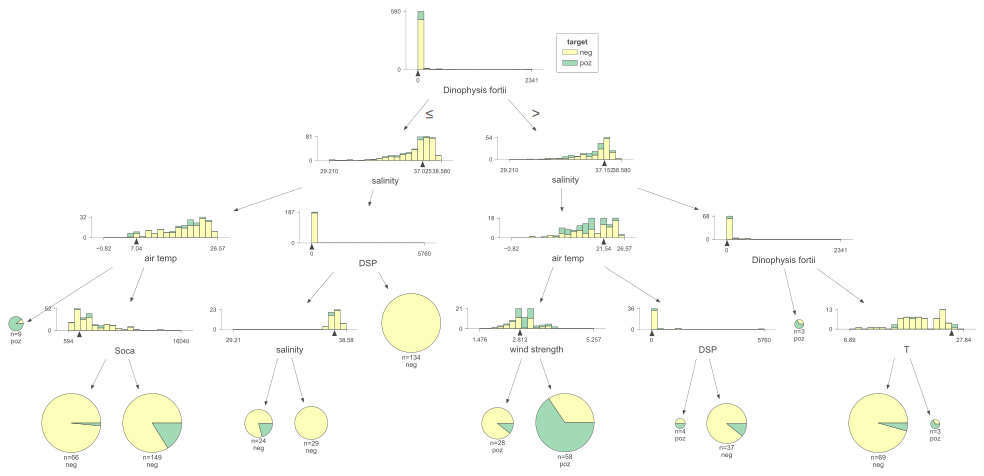

In [26]:
viz = dtreeviz.model(dt_clf, X, y,
                target_name="target",
                feature_names=X.columns,
                class_names=["neg", "poz"],
             # fancy=False,
               # scale=1.5
              )
viz.view()
# # Save the visualization as a PNG file
# viz_file_name = f"{dir_path}/DT_visualisation.svg"
# # viz.save(viz_file_name)
# print(f"Visualization saved as: {viz_file_name}")

# # Display the visualization
# viz

#### Retrain DT with best parameters from gridsearch on a all data

{'clf__class_weight': None, 'clf__criterion': 'entropy', 'clf__max_depth': 4, 'smt__k_neighbors': 3, 'smt__sampling_strategy': 0.3, 'under__sampling_strategy': 0.6}


X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


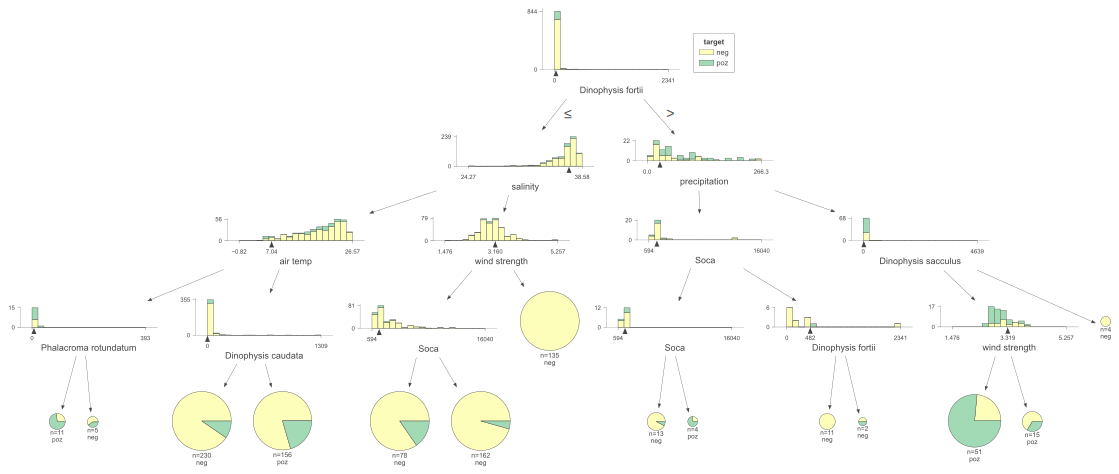

In [27]:
# Retrain DT with best parameters from gridsearch on a all data
best_params = gscv_dt.best_params_

# # Load the data with pickle
# with open('DT_best_params.pkl', 'rb') as f:
#     DT_best_params = pickle.load(f)

print(best_params)

# Create a pipeline with the best parameters
best_pipeline = IMBLpipeline([
    ('smt', SMOTE(sampling_strategy=best_params['smt__sampling_strategy'], k_neighbors=best_params['smt__k_neighbors'], random_state=rand_num)), 
    ('under', RandomUnderSampler(sampling_strategy=best_params['under__sampling_strategy'], random_state=rand_num)), 
    ('clf', DecisionTreeClassifier(max_depth=best_params['clf__max_depth'], criterion=best_params['clf__criterion'], class_weight=best_params['clf__class_weight'], random_state=rand_num))
])

# Train the model on the entire dataset
best_pipeline.fit(X_all, y_all)

# Extract the decision tree classifier from the pipeline
best_dt_clf = best_pipeline.named_steps['clf']

# Save the best decision tree classifier with pickle
with open(f"{dir_path}/best_DT_clf_all_data.pkl-{notebook_name}-{timestamp}.pkl", 'wb') as f:
    pickle.dump(best_dt_clf, f)

#Visualise DT
# from dtreeviz.trees import dtreeviz


viz = dtreeviz.model(best_dt_clf, X_all, y_all,
                target_name="target",
                feature_names=X_all.columns,
                class_names=["neg", "poz"],
                # fancy=False,
                # scale=1.5
                )
viz.view()

# Save the visualization as a PNG file
# viz_file_name = f"{dir_path}/best_DT_visualisation_all-data.svg"
# viz.save(viz_file_name)
# print(f"Visualization saved as: {viz_file_name}")

# Display the visualization
# viz

## Random Forest Model

#### Model evaluation (Random Forest)

In [28]:
# Random forest with grid search for parameters, testing on 5-fold CV with shuffling

pipeline = IMBLpipeline([
   ('smt', SMOTE(random_state=rand_num)), 
   ('under', RandomUnderSampler(random_state=rand_num)), 
    ('clf', RandomForestClassifier(random_state=rand_num))
])

parameters = {
              'clf__n_estimators': [100,300,500],
              'clf__criterion': ['gini', 'entropy', 'log_loss'],
              'clf__class_weight': ['balanced', 'balanced_subsample', None],
              'smt__sampling_strategy': [ 0.2, 0.3, 0.4],
              'under__sampling_strategy': [0.5, 0.6, 0.7],
              'smt__k_neighbors': [3, 5]
             }

nfolds = 5
scores = ['recall', 'precision', 'f1', 'roc_auc']
refit_score = 'f1'
gscv_rf = GridSearchCV(pipeline, 
                    parameters, 
                    scoring=scores,
                    cv=StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=rand_num),
                    return_train_score=False, 
                    verbose=1, 
                    refit=refit_score,
                    n_jobs=-1)
resultsGSCV = gscv_rf.fit(X, y)

# Save the resultsGSCV with pickle
with open(f"{dir_path}/RF_resultsGSCV-{notebook_name}-{timestamp}.pkl", 'wb') as f:
    pickle.dump(resultsGSCV, f)

# Get the classifier name from the pipeline
classifier_name = resultsGSCV.best_estimator_.named_steps['clf'].__class__.__name__
    
# save the best estimator
save_best_estimator(gscv_rf, classifier_name, notebook_name)

# Save best parameters 
RF_best_params = gscv_rf.best_params_
df = pd.DataFrame([RF_best_params])
df.to_csv(f"{dir_path}/RF_best_params-{notebook_name}-{timestamp}.csv", index=False)
# Save with pickle
with open(f"{dir_path}/RF_best_params-{notebook_name}-{timestamp}.pkl", 'wb') as f:
    pickle.dump(RF_best_params, f)
    
results = pd.DataFrame(resultsGSCV.cv_results_)
display(results.sort_values(by=[f'rank_test_f1']).transpose())
pd.set_option("display.max_rows", None)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best estimator saved as: models/07082024_1705/RandomForestClassifier-HAB_modelling_6_8-Review-Check-07082024_1705.pkl


,348,366,186,42,25,49,43,204,456,402,276,222,6,169,19,187,24,...,56,362,173,344,5,113,59,231,285,179,326,353,185,443,389,335,17
mean_fit_time,3.411979,5.392737,3.674709,5.881168,2.675128,6.006107,6.407852,7.950545,3.733059,3.889597,1.605846,2.977777,0.668666,1.357534,1.961292,3.675965,2.747555,...,1.245546,5.416551,1.759383,3.017085,0.610374,1.530619,1.199478,2.973034,1.812994,1.500799,1.0973,3.286648,3.443805,1.107601,0.922868,1.263792,0.729312
std_fit_time,0.024124,0.041416,0.027055,0.105046,0.021273,0.05896,0.25049,0.137235,0.041269,0.039542,0.082572,0.1656,0.004595,0.016433,0.007716,0.059119,0.006751,...,0.067734,0.629554,0.094191,0.041206,0.007483,0.019573,0.022187,0.253613,0.086652,0.043325,0.026963,0.053788,0.083512,0.041353,0.017555,0.023759,0.010712
mean_score_time,0.651963,1.021866,0.442531,1.182646,0.386601,0.857216,1.105164,0.952669,0.547146,0.605471,0.211199,0.394135,0.139191,0.233382,0.342948,0.49037,0.413731,...,0.279306,0.876221,0.238625,0.546433,0.113753,0.276075,0.293618,0.479579,0.416511,0.246595,0.21385,0.671525,0.499769,0.206664,0.169889,0.374759,0.156311
std_score_time,0.125366,0.028956,0.010953,0.102435,0.028323,0.035623,0.146324,0.019564,0.002709,0.024838,0.015632,0.159774,0.012297,0.010555,0.01247,0.031339,0.018218,...,0.034106,0.062226,0.043004,0.017685,0.003764,0.03304,0.011859,0.155866,0.273714,0.021604,0.013472,0.057616,0.012193,0.011424,0.00826,0.008808,0.009818
param_clf__class_weight,None,None,balanced_subsample,balanced,balanced,balanced,balanced,balanced_subsample,None,None,balanced_subsample,balanced_subsample,balanced,balanced_subsample,balanced,balanced_subsample,balanced,...,balanced,None,balanced_subsample,None,balanced,balanced,balanced,balanced_subsample,balanced_subsample,balanced_subsample,None,None,balanced_subsample,None,None,None,balanced
param_clf__criterion,gini,gini,gini,gini,gini,gini,gini,gini,log_loss,entropy,log_loss,entropy,gini,gini,gini,gini,gini,...,entropy,gini,gini,gini,gini,log_loss,entropy,entropy,log_loss,gini,gini,gini,gini,log_loss,entropy,gini,gini
param_clf__n_estimators,300,500,300,500,300,500,500,500,300,300,100,100,100,100,300,300,300,...,100,500,100,300,100,100,100,100,100,100,100,300,300,100,100,100,100
param_smt__k_neighbors,3,3,3,3,3,5,3,3,3,3,3,3,3,3,3,3,3,...,3,3,5,3,3,3,3,5,5,5,3,5,3,5,5,5,5
param_smt__sampling_strategy,0.4,0.4,0.4,0.4,0.4,0.3,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.2,0.4,0.4,...,0.2,0.2,0.2,0.2,0.3,0.3,0.3,0.4,0.4,0.4,0.2,0.2,0.3,0.2,0.2,0.2,0.4
param_under__sampling_strategy,0.5,0.5,0.5,0.5,0.6,0.6,0.6,0.5,0.5,0.5,0.5,0.5,0.5,0.6,0.6,0.6,0.5,...,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.5,0.5,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7


In [29]:
# Evaluation on test data
rf_clf = gscv_rf.best_estimator_.steps[2][1]

# # Load the best estimator from the saved pickle file (replace with acctual file name)
# pickle_file_name = "models/timestamp/classifier_name-notebook_name.pkl"
# rf_clf = load_best_estimator(pickle_file_name).steps[2][1]

# Evaluation RF on test set
y_pred = rf_clf.predict(X_eval)
RF_classification_report = classification_report(y_eval, y_pred)

# Create classification report as dictionary
RF_report_dict = classification_report(y_eval, y_pred, output_dict=True)

print(classification_report(y_eval, y_pred, target_names=["neg", "poz"]))

              precision    recall  f1-score   support

         neg       0.93      0.96      0.95       224
         poz       0.74      0.57      0.65        40

    accuracy                           0.91       264
   macro avg       0.83      0.77      0.80       264
weighted avg       0.90      0.91      0.90       264



Precision-Recall curve: Replicating the cross-validation in GridSearch process manually, using the best parameters found by GridSearchCV to train and evaluate the model on each fold and then plotting the precision-recall curves.

In [30]:
# # Plot the mean precision-recall curve. 

# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import precision_recall_curve, average_precision_score
# import matplotlib.pyplot as plt
# import numpy as np

# # Adjust these values to change the plot size
# plot_width = 10
# plot_height = 8

# cv = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=rand_num)

# mean_recall = np.linspace(0, 1, 100)
# precisions = []
# aucs = []

# # Create a larger plot
# plt.figure(figsize=(plot_width, plot_height))

# for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
#     best_estimator = resultsGSCV.best_estimator_
#     best_estimator.fit(X.iloc[train_idx], y[train_idx]) # Use iloc for X, direct indexing for y
#     probas_ = best_estimator.predict_proba(X.iloc[test_idx]) # Use iloc for X
    
#     # Compute Precision-Recall and plot curve
#     precision, recall, _ = precision_recall_curve(y[test_idx], probas_[:, 1]) # Direct indexing for y
#     precisions.append(np.interp(mean_recall, recall[::-1], precision[::-1]))
#     precisions[-1][0] = 1.0
#     aucs.append(average_precision_score(y[test_idx], probas_[:, 1]))
    
#     plt.plot(recall, precision, lw=1, alpha=0.3, 
#              label=f'Fold {i+1} AP = {aucs[-1]:0.2f}')

# mean_precision = np.mean(precisions, axis=0)
# mean_auc = np.mean(aucs)
# std_auc = np.std(aucs)

# # Plotting the mean precision-recall curve
# plt.plot(mean_recall, mean_precision, color='b',
#          label=r'Mean PR (AP = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
#          lw=2, alpha=0.8)

# plt.xlabel('Recall', fontsize=12)
# plt.ylabel('Precision', fontsize=12)
# # plt.title('Precision-Recall Curve across CV Folds')
# # plt.legend(loc="best")
# plt.savefig(f"{dir_path}/pr_curve-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300, bbox_inches='tight')
# plt.show()


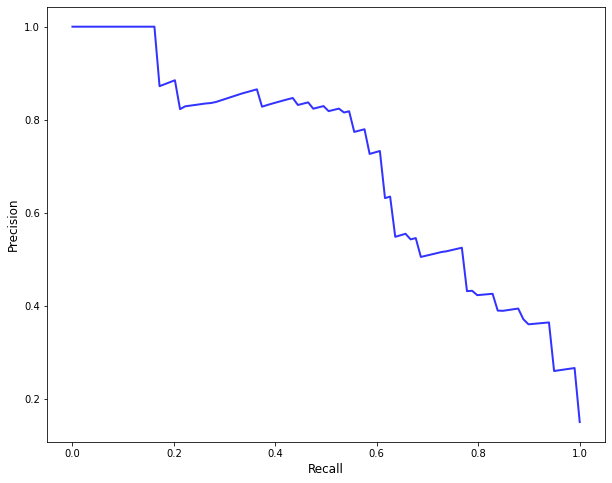

In [35]:
# PR Curve without the fold lines

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Adjust these values to change the plot size
plot_width = 10
plot_height = 8

# Number of folds and random state (assume these are defined)
nfolds = 5
rand_num = 42

# Placeholder for your data and model results
# Assuming X, y, and resultsGSCV are already defined
# X = ...
# y = ...
# resultsGSCV = ...

cv = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=rand_num)

mean_recall = np.linspace(0, 1, 100)
precisions = []
aucs = []

# Create a larger plot
plt.figure(figsize=(plot_width, plot_height))

for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    best_estimator = resultsGSCV.best_estimator_
    best_estimator.fit(X.iloc[train_idx], y[train_idx]) # Use iloc for X, direct indexing for y
    probas_ = best_estimator.predict_proba(X.iloc[test_idx]) # Use iloc for X
    
    # Compute Precision-Recall and plot curve
    precision, recall, _ = precision_recall_curve(y[test_idx], probas_[:, 1]) # Direct indexing for y
    precisions.append(np.interp(mean_recall, recall[::-1], precision[::-1]))
    precisions[-1][0] = 1.0
    aucs.append(average_precision_score(y[test_idx], probas_[:, 1]))
    
    # Comment out the line below to not plot the individual folds
    # plt.plot(recall, precision, lw=1, alpha=0.3, label=f'Fold {i+1} AP = {aucs[-1]:0.2f}')

mean_precision = np.mean(precisions, axis=0)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

# Plotting the mean precision-recall curve
plt.plot(mean_recall, mean_precision, color='b',
         label=r'Mean PR (AP = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=0.8)

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
# plt.title('Precision-Recall Curve across CV Folds')
# plt.legend(loc="best")
plt.savefig(f"{dir_path}/pr_curve-{notebook_name}-{timestamp}.png", format="png", dpi=300, bbox_inches='tight')
plt.show()


Plot the mean ROC curve of the algorithm with best performing parameter selection. We will perform CV once again and plot the ROC curve for each fold and compute and plot the mean.

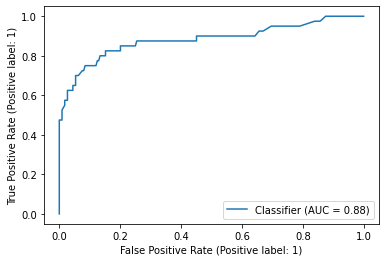

In [36]:
# Plot the ROC curve for RF
from sklearn.metrics import RocCurveDisplay
# # Load the data with pickle
# with open('RF_resultsGSCV.pkl', 'rb') as f:
#     resultsGSCV = pickle.load(f)
clf = resultsGSCV.best_estimator_.steps[2][1]

y_pred = clf.predict_proba(X_eval)[:, 1]
RocCurveDisplay.from_predictions(y_eval, y_pred)
plt.savefig(f"{dir_path}/RF_ROC_curve_noCV-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300)
plt.show()

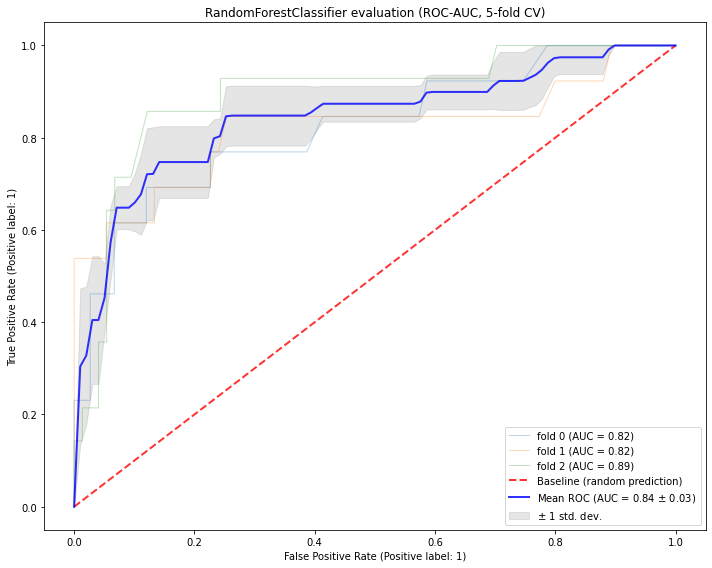

In [37]:
# Plot the ROC curve for RF

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=rand_num)
classifier = resultsGSCV.best_estimator_

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10,8))
for i, (train, test) in enumerate(cv.split(X_eval, y_eval)):
    classifier.fit(X_eval.iloc[train], y_eval[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X_eval.iloc[test],
        y_eval[test],
        name="fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Baseline (random prediction)", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

clfname = [str(step[1].__class__.__name__) for step in classifier.steps if step[0]=='clf'][0]
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f'{clfname} evaluation (ROC-AUC, {nfolds}-fold CV)',
)
ax.legend(loc="lower right")
plt.tight_layout()
# plt.savefig(f"{dir_path}/RF_ROC_curve-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300)
plt.show()

#### Feature importance (Random Forest)

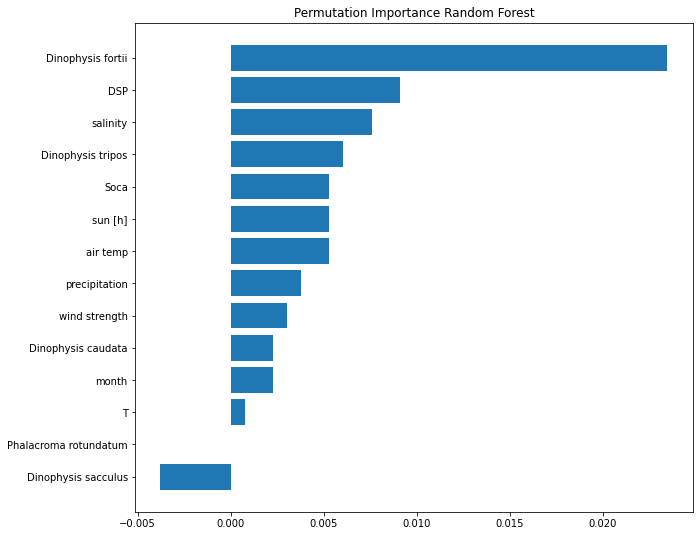

In [38]:
# Feature importance of model (best RandomForest from gridsearch) with three methods!

fig, (ax2) = plt.subplots(1, 1, figsize=(10,9))
plt.subplots_adjust(wspace=1.1)

# Get feature importance with Permutation Based Feature Importance (randomly shuffles each feature and compute the 
# change in the model’s performance. The features which impact the performance the most are the most important one).
perm_importance = permutation_importance(rf_clf, X_eval, y_eval, random_state=rand_num)
perm_sorted_idx = perm_importance.importances_mean.argsort()
x2 = X_eval.columns[perm_sorted_idx]
y2 = perm_importance.importances_mean[perm_sorted_idx]
ax2.barh(x2, y2)
ax2.set_title("Permutation Importance Random Forest")
plt.savefig(f"{dir_path}/permutation_importance_RF-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300, bbox_inches='tight')

### SHAP

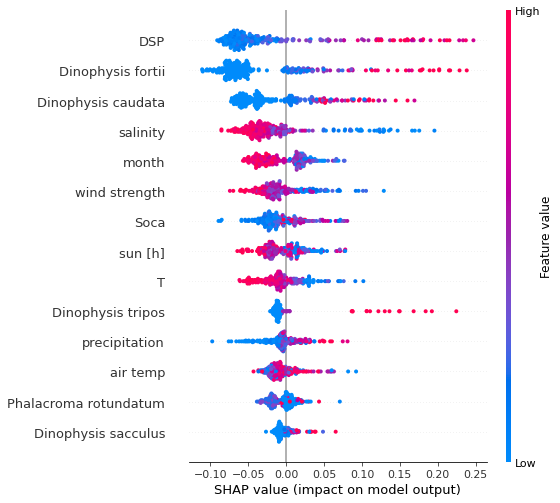

In [39]:
# SHAP summary plot
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(X_eval)
classid = 1

# Save shap.summary_plot()
fig = shap.summary_plot(shap_values[classid], X_eval, max_display=len(X_eval.columns), class_names=le.classes_, show=False)
plt.savefig(f"{dir_path}/shap_summary_plot-{classifier_name}-{notebook_name}-{timestamp}.pdf", format="pdf", bbox_inches='tight')

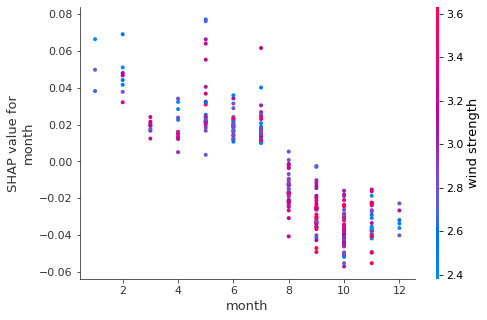

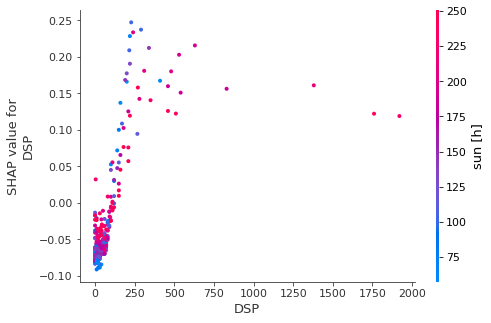

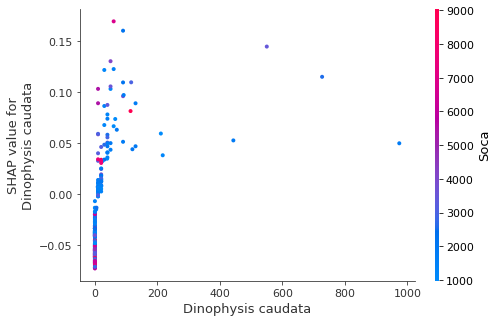

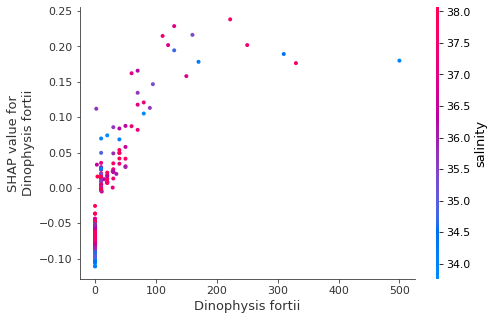

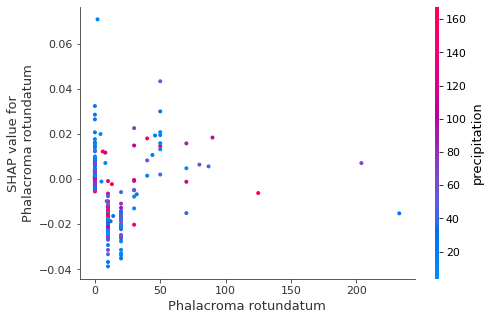

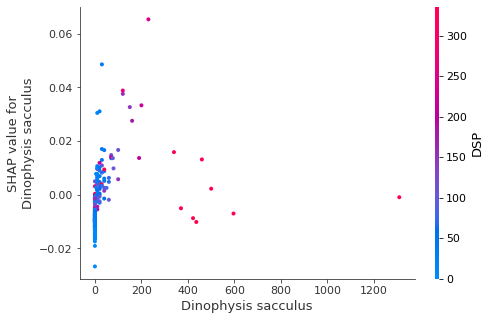

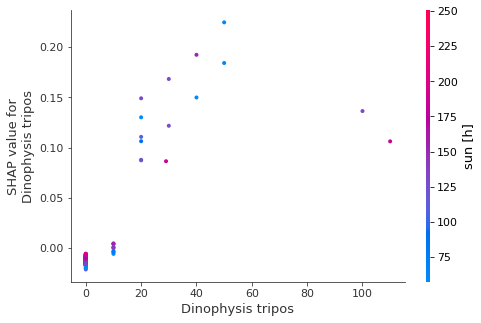

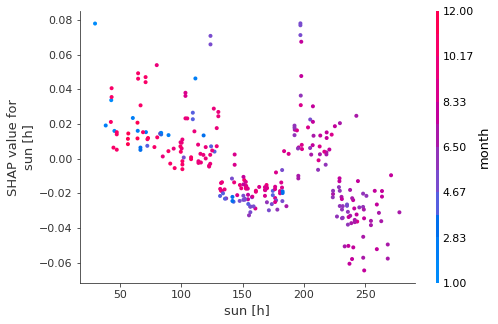

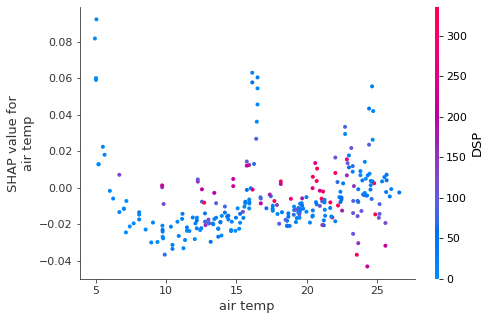

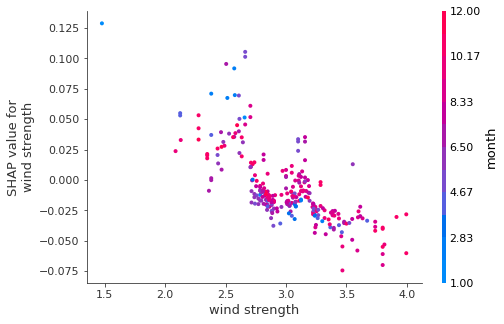

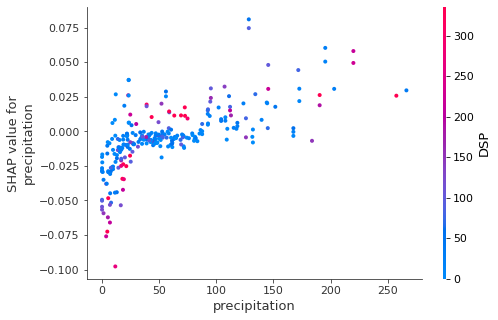

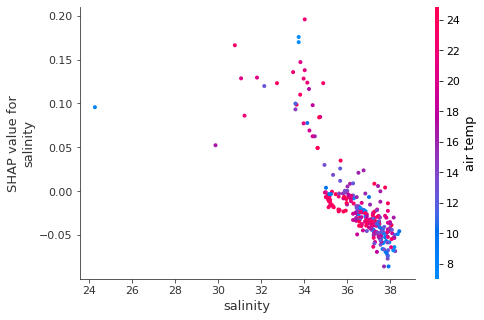

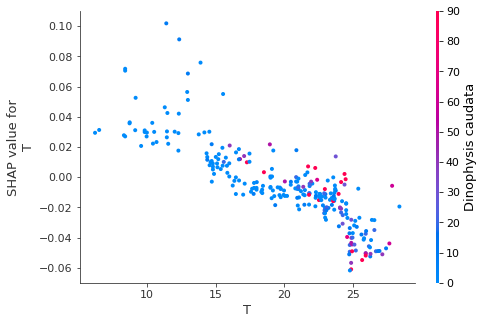

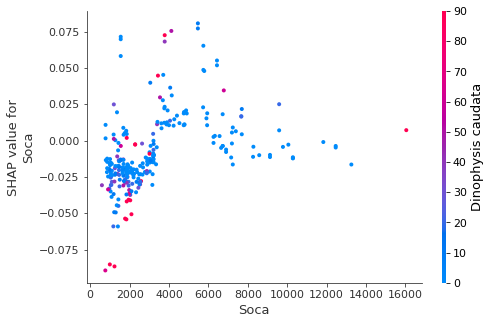

In [40]:
# Try dependence contribution plot
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(X_eval)
for i in X_eval.columns:
    shap.dependence_plot(i, shap_values[1], X_eval) #interaction_index="salinity"

### Exaplain individual prediction with SHAP

In [47]:
# explain positive example prediction 
correct_indices = np.where((y_eval == 1) & (rf_clf.predict(X_eval) == y_eval))[0]

# instanceID = correct_indices[1]
instanceID = 92

instance = X_eval.iloc[[instanceID]]
display_instance = X_eval.iloc[[instanceID]]

prediction = rf_clf.predict(instance)[0]
prediction_probs = rf_clf.predict_proba(instance)[0]
print(f'real value: {y_eval[instanceID]}, \npredicted: {prediction}, \npredicted probs: {prediction_probs}')
max_p_id = prediction_probs.argmax()  # we will show the explanation of the bigger predicted probability
print(f'Explanation for prediction: class={max_p_id}, p={prediction_probs.max()}')

explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(instance)
shap.force_plot(explainer.expected_value[max_p_id], shap_values[max_p_id], features=display_instance)
# plt.savefig(f"{dir_path}/shap_force_plot-{classifier_name}-{notebook_name}-{timestamp}.pdf", format="pdf", bbox_inches='tight')

real value: 1, 
predicted: 1, 
predicted probs: [0.36666667 0.63333333]
Explanation for prediction: class=1, p=0.6333333333333333


In [42]:
# explain negative example prediction 
correct_indices = np.where((y_eval == 0) & (rf_clf.predict(X_eval) == y_eval))[0]

instanceID = correct_indices[1]
# instanceID = 135

instance = X_eval.iloc[[instanceID]]
display_instance = X_eval.iloc[[instanceID]]

prediction = rf_clf.predict(instance)[0]
prediction_probs = rf_clf.predict_proba(instance)[0]
print(f'real value: {y_eval[instanceID]}, \npredicted: {prediction}, \npredicted probs: {prediction_probs}')
max_p_id = prediction_probs.argmax()  # we will show the explanation of the bigger predicted probability
print(f'Explanation for prediction: class={max_p_id}, p={prediction_probs.max()}')

explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(instance)
shap.force_plot(explainer.expected_value[max_p_id], shap_values[max_p_id], features=display_instance)

real value: 0, 
predicted: 0, 
predicted probs: [0.81666667 0.18333333]
Explanation for prediction: class=0, p=0.8166666666666667


### Neural Network Model

#### Model Evaluation (MLP)

In [ ]:
# Preprocessing for NN in scikit_learn

# Model evaluation with the pipeline of SMOTE oversampling and undersampling on the training dataset only (within each cross-validation fold)!

#Remove months from X
Xnn = X.drop(X.columns[0], axis=1)

X_display = Xnn.copy()  # *used for SHAP visualization so we can show unscaled values

# scalling numeric values for NN
scaled_array = StandardScaler().fit_transform(Xnn)
Xsc = pd.DataFrame(scaled_array, columns=Xnn.columns)

In [ ]:
# MLP with grid search for parameters, testing on 5-fold CV with shuffling

pipeline = IMBLpipeline([
    ('over', SMOTE(random_state=rand_num)),
    ('under', RandomUnderSampler(random_state=rand_num)),
    ('clf', MLPClassifier(solver='lbfgs', max_iter=5000, random_state=rand_num))
])

parameters = {'over__k_neighbors': range(1,7),
              'over__sampling_strategy': [0.5, 0.6, 0.8], # probaj poveča ovresampling do 0.9
              'under__sampling_strategy': [0.6, 0.7, 0.8],
              'clf__hidden_layer_sizes': [(2, ), (2, 2), (3,), (3,3)],
              'clf__solver': ['lbfgs', 'sgd', 'adam']
             }
nfolds = 5
scores = ['recall', "precision", 'f1', 'roc_auc']
gscv_NN = GridSearchCV(pipeline, 
                    parameters, 
                    scoring=scores,
                    cv=StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=rand_num),
                    n_jobs= -1, 
                    return_train_score=False, 
                    verbose=1, 
                    refit= "f1")
resultsGSCV = gscv_NN.fit(Xsc, y)

# Save the resultsGSCV with pickle
with open('MLP_resultsGSCV.pkl', 'wb') as f:
    pickle.dump(resultsGSCV, f)

# Get the classifier name from the pipeline
classifier_name = resultsGSCV.best_estimator_.named_steps['clf'].__class__.__name__
    
# save the best estimator
save_best_estimator(gscv_NN, classifier_name, notebook_name)

# Save best parameters 
MLP_best_params = gscv_NN.best_params_
df = pd.DataFrame([MLP_best_params])
df.to_csv(f"{dir_path}/MLP_best_params-{notebook_name}-{timestamp}.csv", index=False)
# Save with pickle
with open(f"{dir_path}/MLP_best_params-{notebook_name}-{timestamp}.pkl", 'wb') as f:
    pickle.dump(MLP_best_params, f)

results = pd.DataFrame(resultsGSCV.cv_results_)
display(results.sort_values(by=[f'rank_test_f1']).transpose())

In [ ]:
# Evaluation on test data
nn_clf = gscv_NN.best_estimator_.steps[2][1]

# # Load the best estimator from the saved pickle file (replace with acctual file name)
# pickle_file_name = "models/timestamp/classifier_name-notebook_name.pkl"
# nn_clf = load_best_estimator(pickle_file_name).steps[2][1]

# Evaluation of NN on test set
X_eval_nn = X_eval.drop(X_eval.columns[0], axis=1)
X_eval_display = X_eval_nn.copy()

scaler = StandardScaler().fit(Xnn)
X_eval_sc = scaler.transform(X_eval_nn)
X_eval_sc = pd.DataFrame(X_eval_sc, columns=Xnn.columns)
y_pred = nn_clf.predict(X_eval_sc)
NN_classification_report = classification_report(y_eval, y_pred)

# Create classification report as dictionary
NN_report_dict = classification_report(y_eval, y_pred, output_dict=True)

print(classification_report(y_eval, y_pred, target_names=["neg", "poz"]))

In [ ]:
# Plot the ROC curve for MLP (Check code as moved form RF!). 

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=3, shuffle=True)
classifier = resultsGSCV.best_estimator_

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10,8))
for i, (train, test) in enumerate(cv.split(X_eval_sc, y_eval)):
    classifier.fit(X_eval_sc.iloc[train], y_eval[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X_eval_sc.iloc[test],
        y_eval[test],
        name="fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Baseline (random prediction)", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

clfname = [str(step[1].__class__.__name__) for step in classifier.steps if step[0]=='clf'][0]
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f'{clfname} evaluation (ROC-AUC, {nfolds}-fold CV)',
)
ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig(f"{dir_path}/MLP_ROC_curve-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300)
plt.show()

In [ ]:
# Plot the mean precision-recall curve for MLP (Check code as moved form RF!). 

from sklearn.metrics import PrecisionRecallDisplay

cv = StratifiedKFold(n_splits=3, shuffle=True)
classifier = resultsGSCV.best_estimator_

prs = []
aucs = []
mean_r = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10,8))
for i, (train, test) in enumerate(cv.split(X_eval_sc, y_eval)):
    classifier.fit(X_eval_sc.iloc[train], y_eval[train])
    viz = PrecisionRecallDisplay.from_estimator(
        classifier,
        X_eval_sc.iloc[test],
        y_eval[test],
        name="fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_pr = np.interp(mean_r, viz.recall[::-1], viz.precision[::-1])
    prs.append(interp_pr)

mean_p = np.mean(prs, axis=0)
ax.plot(
    mean_r,
    mean_p,
    color="b",
    label=f"mean",
    lw=2,
    alpha=0.8,
)
ax.legend(loc="lower left")
clfname = [str(step[1].__class__.__name__) for step in classifier.steps if step[0]=='clf'][0]
ax.set(
    # xlim=[-0.05, 1.05],
    # ylim=[-0.05, 1.05],
    title=f'{clfname} evaluation (precision-recall, {nfolds}-fold CV)')
plt.tight_layout()
plt.savefig(f"{dir_path}/MLP_precision-recall_curve-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300)
plt.show()

#### Feature Importance (MLP)

In [ ]:
# Feature importance of model (best MLP from gridsearch) with three methods!

fig, (ax2) = plt.subplots(1, 1, figsize=(10,9))
plt.subplots_adjust(wspace=1.1)

# Get feature importance with Permutation Based Feature Importance (randomly shuffles each feature and compute the 
# change in the model’s performance. The features which impact the performance the most are the most important one).
perm_importance = permutation_importance(nn_clf, X_eval_sc, y_eval, random_state=rand_num)
perm_sorted_idx = perm_importance.importances_mean.argsort()
x2 = X_eval_sc.columns[perm_sorted_idx]
y2 = perm_importance.importances_mean[perm_sorted_idx]
ax2.barh(x2, y2)
ax2.set_title("Permutation Importance MLP")
plt.savefig(f"{dir_path}/permutation_importance_MLP-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300, bbox_inches='tight')

#### Feature importance with SHAP

First, visualize the impact of all features on both classes in one chart. We are using KernelExplainer but simpler general Explainer should be also tested once the SHAP code fixes all bugs.

**Note: SHAP explanations change between runs because of sampling and probably other random factors!**

In [ ]:
# # explain the model's predictions using SHAP
# import shap
# import warnings
# warnings.filterwarnings("ignore")
# shap.initjs()

# explainer = shap.KernelExplainer(NN_model.predict_proba, shap.sample(X_eval_sc,20))
# shap_values = explainer.shap_values(X_eval_sc, nsamples=50)
# shap.summary_plot(shap_values, X_eval_sc, max_display=len(X.columns), class_names=le.classes_)

Now for each class separately. We observe the impact of features on the returned model's probability for a given class.

In [ ]:
warnings.filterwarnings("ignore")
shap.initjs()

explainer = shap.KernelExplainer(nn_clf.predict_proba, shap.sample(X_eval_sc, 50))
shap_values = explainer.shap_values(X_eval_sc, nsamples=50)
classid = 1

# Save shap.summary_plot()
fig = shap.summary_plot(shap_values[classid], X_eval_display, max_display=len(X_eval_display.columns), class_names=le.classes_, show=False)
plt.savefig(f"{dir_path}/shap_summary_plot-{classifier_name}-{notebook_name}-{timestamp}.pdf", format="pdf", bbox_inches='tight')

In [ ]:
# Try dependence contribution plot
explainer = shap.KernelExplainer(nn_clf.predict_proba, shap.sample(X_eval_sc, 50))
shap_values = explainer.shap_values(X_eval_sc, nsamples=50)

for i in X_eval_display.columns:
    shap.dependence_plot(i, shap_values[1], X_eval_display,) #interaction_index="salinity"

Example intepretation: The fact this slopes upward says the higher the soca flow, the higher the model's prediction is for poz/neg. The spread suggests that other features must interact with Soca flow. 
In general, high Soca flow increases the chance of poz/neg. But if the sea temp is moderate or low, that trend reverses and even high soca flow does not increase preditions of poz/neg as the sea temp is too low.
https://www.kaggle.com/code/dansbecker/advanced-uses-of-shap-values
---- 
To interpret the dependence contribution plot, look for trends or patterns in the relationship between the 'salinity' feature values and their SHAP values. For example:

If the points show a clear positive trend, it means that as the 'salinity' value increases, its positive contribution to the model's prediction also increases.
If the points show a clear negative trend, it means that as the 'salinity' value increases, its negative contribution to the model's prediction increases (i.e., higher 'salinity' values decrease the probability of class 1).
If there is no clear trend or the points are scattered randomly, it means that there is no strong relationship between the 'salinity' feature values and their SHAP values.
Additionally, observe the colors of the points in the plot. If there is a clear pattern in the colors, it may indicate that the interaction between 'salinity' and the interaction feature has a significant impact on the model's predictions. This can help you identify interactions between features that the model is capturing.

Now let's explain the prediction of a single instance. We will show the explanation of the bigger predicted probability to see why the model decided as it did. But in practice we could be interested only in the explanation of the probability of the positive prediction.

In [ ]:
# explain positive example prediction 
correct_indices = np.where((y_eval == 1) & (nn_clf.predict(X_eval_sc) == y_eval))[0]

instanceID = correct_indices[0]
instance = X_eval_sc.iloc[[instanceID]]
display_instance = X_eval_display.iloc[[instanceID]]

prediction = nn_clf.predict(instance)[0]
prediction_probs = nn_clf.predict_proba(instance)[0]
print(f'real value: {y_eval[instanceID]}, \npredicted: {prediction}, \npredicted probs: {prediction_probs}')
max_p_id = prediction_probs.argmax()  # we will show the explanation of the bigger predicted probability
print(f'Explanation for prediction: class={max_p_id}, p={prediction_probs.max()}')

explainer = shap.KernelExplainer(nn_clf.predict_proba, shap.sample(Xsc, 50))
shap_values = explainer.shap_values(instance, nsamples=500)
shap.force_plot(explainer.expected_value[max_p_id], shap_values[max_p_id], features=display_instance)

In [ ]:
# explain negative example prediction 
correct_indices = np.where((y_eval == 0) & (nn_clf.predict(X_eval_sc) == y_eval))[0]

instanceID = correct_indices[0]
instance = X_eval_sc.iloc[[instanceID]]
display_instance = X_eval_display.iloc[[instanceID]]

prediction = nn_clf.predict(instance)[0]
prediction_probs = nn_clf.predict_proba(instance)[0]
print(f'real value: {y_eval[instanceID]}, \npredicted: {prediction}, \npredicted probs: {prediction_probs}')
max_p_id = prediction_probs.argmax()  # we will show the explanation of the bigger predicted probability
print(f'Explanation for prediction: class={max_p_id}, p={prediction_probs.max()}')

explainer = shap.KernelExplainer(nn_clf.predict_proba, shap.sample(Xsc, 50))
shap_values = explainer.shap_values(instance, nsamples=500)
shap.force_plot(explainer.expected_value[max_p_id], shap_values[max_p_id], features=display_instance)

Interpretation:

Observe the base value (Expected value) and the prediction line. This gives you an idea of the overall prediction for the instance compared to the average prediction.

Look at the colored arrows and identify the most important features, which are the ones with the longest arrows. These features have the greatest impact on the prediction.

Analyze the direction and color of the arrows to understand whether each feature increases or decreases the probability of the positive class (class 1) and whether the feature values are high or low.

Consider the interactions between the features and their combined impact on the prediction.

By analyzing the force plot, you can gain insights into the contributions of each feature to the model's prediction for a specific instance, helping you understand the model's decision-making process.

### LIME

In [ ]:
import lime
from lime import lime_tabular

# Create a LIME explainer object
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(Xsc),
    feature_names=Xsc.columns,
    class_names=le.classes_,
    mode='classification'
)

# Exaplain an instance
instanceID = 100
lime_exp = lime_explainer.explain_instance(
    data_row=Xsc.iloc[instanceID], 
    predict_fn=nn_clf.predict_proba
)

lime_exp.show_in_notebook(show_table=True)

# Save the LIME explanation as an image file
# fig = lime_exp.as_pyplot_figure(label=1)
# plt.savefig(f"{dir_path}/lime_explanation-{classifier_name}-{notebook_name}-{timestamp}.pdf", format="pdf", bbox_inches='tight')

### Conclusion

In [ ]:
# Define a function to extract the metrics from the classification report dictionary
def extract_metrics(report_dict):
    metrics = {}
    for class_label in report_dict:
        if class_label in ('accuracy', 'macro avg', 'weighted avg'):
            continue
        metrics[class_label] = {
            'precision': report_dict[class_label]['precision'],
            'recall': report_dict[class_label]['recall'],
            'f1-score': report_dict[class_label]['f1-score'],
            'support': report_dict[class_label]['support']
        }
    return metrics

# Extract the metrics for each classifier
SVM_metrics = extract_metrics(SVM_report_dict)
DT_metrics = extract_metrics(DT_report_dict)
RF_metrics = extract_metrics(RF_report_dict)
NN_metrics = extract_metrics(NN_report_dict)

# Create a dictionary to store the metrics for each classifier
classifier_metrics = {
    'Support Vector Machines': SVM_metrics,
    'Decision Tree': DT_metrics,
    'Random Forest': RF_metrics,
    'Neural Network': NN_metrics
}

# Convert the dictionary to a pandas DataFrame
summary_df = pd.concat({k: pd.DataFrame(v).transpose() for k, v in classifier_metrics.items()}, axis=0)
summary_df.reset_index(inplace=True)
summary_df.columns = ['Classifier', 'Class', 'Precision', 'Recall', 'F1-score', 'Support']

# Map the original class labels to the new names
class_name_mapping = {
    '0': 'neg',
    '1': 'poz'
}
summary_df['Class'] = summary_df['Class'].map(class_name_mapping)

# Filter the summary DataFrame to display only the 'poz' class
poz_summary_df = summary_df.query("Class == 'poz'")

# Display the filtered summary DataFrame
poz_summary_df

In [ ]:
# Format table

poz_summary_df = poz_summary_df.round(2)
# poz_summary_df = poz_summary_df.set_index('Classifier')
poz_summary_df = poz_summary_df.drop(['Support', "Class"], axis=1)
# poz_summary_df = poz_summary_df.style.highlight_max(subset=['Precision', 'Recall', 'F1-score'], color='green')
poz_summary_df.to_csv(f"{dir_path}/results_summary_df.csv")
poz_summary_df["Timestamp"] = timestamp
poz_summary_df

In [ ]:
# # Add results to results to results df
# df_results = pd.read_pickle("data/results/df_results_3_0")
# df_results

In [ ]:
# df_results = df_results.append(poz_summary_df)
# df_results.to_pickle("data/results/df_results_3_0")
# df_results